In [1]:
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset
import os
import sys
sys.path.append(os.path.abspath(".."))
from utils.degree_day_equations import *
from utils.net_cdf_functions import *
from utils.processing_functions import *
#from utils.visualization_functions import *

import pandas as pd
#from visualization_functions import *
import numpy as np
data_path =  "../data/"

In [54]:
from dask import delayed
import time
def fflies_model_1(data, start, threshold):
    # Ensure data is an xarray DataArray
    if isinstance(data, np.ndarray):
        data = xr.DataArray(data)
    
    # Initialize cumulative sum and elapsed days
    cumsum = 0
    elapsed_days = 0
    
    # Iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        # Add the value of the current position to the cumsum
        if np.isnan(data[i]):
            return -1
        cumsum += data[i]
        # Increment the elapsed days
        elapsed_days += 1
        # If the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:

            return elapsed_days
    
    # If the end of the array is reached, start over from the beginning and keep counting
    for i in range(0, start):
        cumsum += data[i]
        elapsed_days += 1
        if cumsum >= threshold:
            return elapsed_days
    
    # If the threshold is not reached, return the total number of days
    return elapsed_days
def apply_fflies_model_run(data, date, dd_threshold=754):
    # Apply the wrapper function over the x and y dimensions
    result = xr.apply_ufunc(
        fflies_model_1,
        data,
        date,
        dd_threshold,
        input_core_dims=[['t'], [], []],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
        
    )
    result.name = 'days_to_f3'
    result = result.where(result != -1, np.nan)
    return result


import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import datetime

def plot_xr_with_point_and_circle(data, point_coords, circle_radius_km = 15, alpha=.8):
    #data is an xarray DataArray
    point_lon = point_coords[1]
    point_lat = point_coords[0]
    # Create a plot with a basemap
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    #ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add an OSM basemap
    osm = cimgt.OSM()
    ax.add_image(osm, 10)
    
    # Plot the data
    data.plot(ax=ax, cmap='viridis', alpha=alpha, transform=ccrs.PlateCarree(), add_colorbar=True, vmin=-5, vmax=170,cbar_kwargs={'label': 'Days to F3'})
    

    #create date from day of year

    date = datetime.datetime(2001, 1, 1) + datetime.timedelta(240 - 1)
    # Plot the point
    ax.plot(point_lon, point_lat, 'ro', markersize=10, transform=ccrs.PlateCarree())
    
    # Plot the circle
    circle_radius_deg = circle_radius_km / 111.32  # Convert radius from km to degrees (approximation)
    circle = Circle((point_lon, point_lat), circle_radius_deg, color='red', fill=False, transform=ccrs.PlateCarree())
    ax.add_patch(circle)
    
    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Days to F3 Completion beginning on ' + date.strftime('%Y-%m-%d'))
    

    
    # Show the plot
    plt.show()

In [55]:
def run_plot_DD(start_dates, coordinates, target_species):
    # Define degree day models for different species
    fly_models = {
        "Mexfly": {"UTT": 999, "LTT": 9.4, "dd_threshold": 754},
        "OFF": {"UTT": 999, "LTT": 8.375, "dd_threshold": 625},
        "Medfly": {"UTT": 999, "LTT": 12.44, "dd_threshold": 346},
        "Z. tau": {"UTT": 999, "LTT": 9.22, "dd_threshold": 459.28},
    }
    
    # Get parameters for the target species
    fly_params = fly_models[target_species]
    if len(coordinates) != len(start_dates):
        raise ValueError("Number of coordinates and dates do not match")
    # Determine the bounding box for the coordinates
    if len(coordinates) > 1:
        lats, lons = zip(*coordinates)
        coordinates_bbox = (min(lons), max(lons), min(lats), max(lats))
    elif len(coordinates) == 1:
        lats, lons = coordinates[0]
        coordinates_bbox = (lons - 0.3, lons + 0.3, lats - 0.3, lats + 0.3)

    else:
        print("No coordinates supplied")
        raise ValueError("No coordinates supplied")
    
    # Determine the start and end dates for fetching data
    start_date = min(start_dates)
    end_date = max(start_dates) + timedelta(days = 5 )
    n_days = (end_date - start_date).days
    start_date_str = start_date.strftime('%Y-%m-%d')
    
    # Check if the date range is valid for fetching data
    if start_date < pd.Timestamp('1999-01-01'):
        raise ValueError("Start date is too early")
    elif end_date > pd.Timestamp.now() - pd.Timedelta(days=2):
        raise ValueError("Predicted data not available for this date range - gotta fix this")
        '''
        # Example code for fetching predicted data (commented out)
        weather_end_date = pd.Timestamp.now() - pd.Timedelta(days=2)
        weather_end_date_str = weather_end_date.strftime('%Y-%m-%d')
        raw_PRISM = fetch_ncss_data(start_date=start_date_str, end_date=weather_end_date_str, bbox=coordinates_bbox)
        predicted_PRISM = for year in range(pd.Timestamp.now().year - pd.Timedelta(years=20), end_date.year + 1):
        '''
    else:
        # Fetch historical data
        raw_PRISM = fetch_ncss_data(start_date=start_date_str, n_days=n_days, bbox=coordinates_bbox)
        DD_data = da_calculate_degree_days(fly_params['LTT'], fly_params['UTT'], raw_PRISM)


    #if we recieve a single point , we will produce a context map with that date
    # if we recieve multiple points, we will just output the completion dates
    if len(coordinates) == 1:
       time_index = np.argwhere(DD_data.t.values == np.datetime64(start_dates[0])).flatten()[0]
       model_output = apply_fflies_model_run(DD_data, time_index, fly_params['dd_threshold'])
    return plot_xr_with_point_and_circle(model_output, coordinates[0])

    return 0

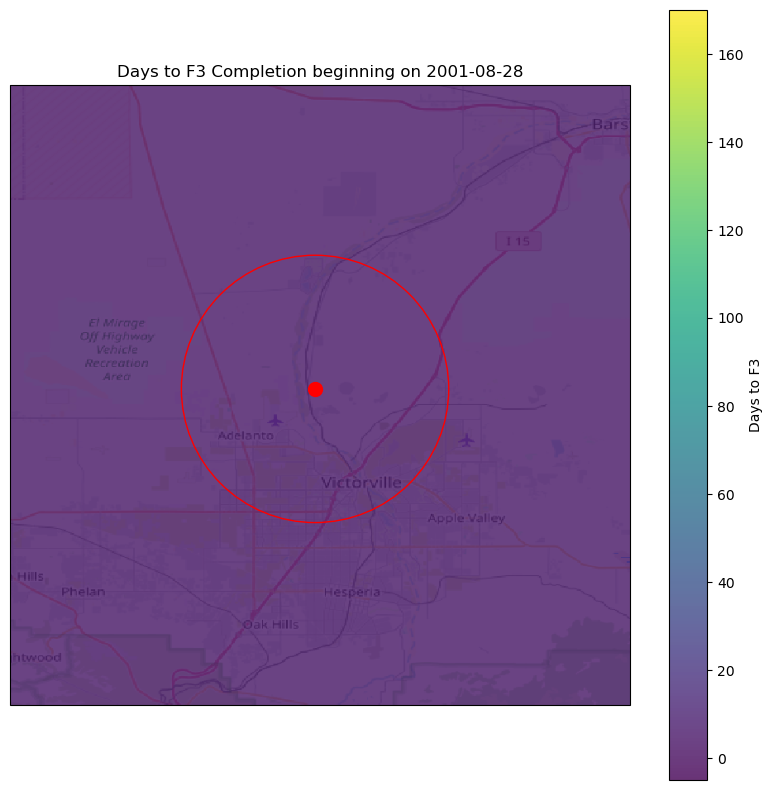

In [56]:
run_plot_DD([pd.to_datetime('2020-01-01')], [(34.63115, -117.338321)], 'Mexfly')